# Visual artifact creation

## Imports

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

## Consts

In [2]:
# 

## Functions

In [37]:
def apply_ghosting(img, trail_length=10, trail_decay=0.8, shift_x=5, shift_y=5):
    height, width, channels = img.shape
    ghosted_img = np.zeros((height, width, channels), np.float32)

    for i in range(trail_length):
        shift = np.array([shift_x * i, shift_y * i], np.float32)
        shifted = cv2.warpAffine(
            img, 
            np.float32(
                [[1, 0, shift[0]], 
                [0, 1, shift[1]]]
            ), 
            (width, height)
            )
        ghosted_img += shifted * trail_decay**i

    ghosted_img = ghosted_img / np.max(ghosted_img) * 255

    return np.uint8(np.clip(ghosted_img, 0, 255))


def apply_distortion(img, displacement=10):
    height, width, channels = img.shape
    displacement_map = np.random.uniform(-displacement,
                                         displacement, size=(height, width, 2))
    displacement_map = cv2.GaussianBlur(displacement_map, (5, 5), 0)
    mesh_x, mesh_y = np.meshgrid(np.arange(width), np.arange(height))
    mesh_x = mesh_x.astype(np.float32) + displacement_map[:, :, 0]
    mesh_y = mesh_y.astype(np.float32) + displacement_map[:, :, 1]

    mesh_x = mesh_x.astype(np.float32)
    mesh_y = mesh_y.astype(np.float32)
    return cv2.remap(img, mesh_x, mesh_y, cv2.INTER_LINEAR, borderMode=cv2.BORDER_REPLICATE)


def apply_color_banding(img, levels=8):
    height, width, channels = img.shape
    quantized = np.uint8(
        np.round(img / (256 / levels))
        ) * (256 // levels)

    return quantized


def apply_silk_screen_effect(img, levels=8, threshold=128):
    height, width, channels = img.shape
    quantized = np.uint8(np.round(img / (256 / levels))) * (256 // levels)
    bw = cv2.cvtColor(quantized, cv2.COLOR_BGR2GRAY)
    _, bw = cv2.threshold(bw, threshold, 255, cv2.THRESH_BINARY)
    bw = cv2.cvtColor(bw, cv2.COLOR_GRAY2BGR)
    return bw


def apply_rainbow_effect(img, strength=10):
    height, width, channels = img.shape
    hue_map = np.zeros((height, width, 3), dtype=np.float32)
    hue_map[:, :, 0] = np.linspace(0, strength, width)
    hue_map = cv2.GaussianBlur(hue_map, (5, 5), 0)
    hue_map = hue_map * 360 / strength
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    hsv[:, :, 0] = hsv[:, :, 0] + hue_map[:, :, 0]
    hsv[:, :, 0][hsv[:, :, 0] > 360] = hsv[:, :, 0][hsv[:, :, 0] > 360] - 360
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)


def apply_noise(image, noise_type='gaussian', mean=0, var=0.001):
    if noise_type == 'gaussian':
        noise = np.random.normal(mean, var ** 0.5, image.shape)
        return np.clip(image + noise, 0, 255).astype(np.uint8)
    elif noise_type == 'salt-and-pepper':
        s_vs_p = 0.5
        amount = 0.004
        out = np.copy(image)
        # Salt mode
        num_salt = np.ceil(amount * image.size * s_vs_p)
        coords = [np.random.randint(0, i - 1, int(num_salt))
                  for i in image.shape]
        out[coords] = 255
        # Pepper mode
        num_pepper = np.ceil(amount * image.size * (1. - s_vs_p))
        coords = [np.random.randint(0, i - 1, int(num_pepper))
                  for i in image.shape]
        out[coords] = 0
        return out
    else:
        return image


def apply_screen_tearing(image, strength=0.5, direction='horizontal'):
    height, width, channels = image.shape
    tear = np.zeros(image.shape, dtype=np.uint8)

    if direction == 'horizontal':
        tearing_height = int(strength * height)
        tear[:tearing_height, :, :] = image[:tearing_height, :, :]
        tear[tearing_height:, :, :] = image[:-tearing_height, :, :]
    elif direction == 'vertical':
        tearing_width = int(strength * width)
        tear[:, :tearing_width, :] = image[:, :tearing_width, :]
        tear[:, tearing_width:, :] = image[:, :-tearing_width, :]
    else:
        raise ValueError("Invalid direction")

    return tear



def apply_compression_artifact(image, quality=50):
    params = [int(cv2.IMWRITE_JPEG_QUALITY), quality]
    _, enc = cv2.imencode('.jpg', image, params)
    return cv2.imdecode(enc, 1)


def apply_moire_pattern(image, strength=50, wavelength=100, angle=45, grid_size=10):
    height, width = image.shape[:2]

    x, y = np.meshgrid(np.linspace(0, width, grid_size),
                       np.linspace(0, height, grid_size))
    x = x * wavelength * np.pi / 180
    y = y * wavelength * np.pi / 180
    moire = np.sin(x + y) * strength / 100
    moire = cv2.resize(moire, (width, height), interpolation=cv2.INTER_CUBIC)
    moire = np.repeat(moire[:, :, np.newaxis], image.shape[-1], axis=-1)
    moire = moire.astype(image.dtype)

    return cv2.addWeighted(image, 1, moire, strength / 100, 0).astype(np.uint8)


## Examples

In [4]:
def plot_2_examples(original: np.ndarray, with_artifacts: np.ndarray, artifact_name: str, figsize: tuple[int, int] = (27, 10)) -> None:
    fig, axs = plt.subplots(1, 2, figsize=figsize)

    axs[0].imshow(original)
    axs[1].imshow(with_artifacts)
    axs[0].set_title('Original image')
    axs[1].set_title(f'{artifact_name} image')
    plt.show()


def plot_x_examples(original: np.ndarray, with_artifacts: list[np.ndarray], artifact_names: list[str], figsize: tuple[int, int] = (27, 10)) -> None:
    fig, axs = plt.subplots(3, 3, figsize=figsize, sharex='all', sharey='all')

    axs = axs.flatten()

    axs[0].imshow(original)
    axs[0].set_title('Original image')

    for idx in range(1,len(axs)):
        axs[idx].imshow(with_artifacts[idx-1])
        axs[idx].set_title(f'{artifact_names[idx-1]} image')
    
    plt.show()

In [10]:
im = cv2.imread('../image.jpg')

In [41]:
im_ghosting = apply_ghosting(im, trail_length=10, trail_decay=0.5, shift_x=20)
im_distortion = apply_distortion(im)
im_banding = apply_color_banding(im)
im_rainbow = apply_rainbow_effect(im)
im_silk_screen = apply_silk_screen_effect(im)
im_tearing = apply_screen_tearing(im, strength=0.3)
im_noise = apply_noise(im, mean=128, var=15)
im_moire = apply_moire_pattern(im, strength=150, wavelength=200, grid_size=1000)

images = [
    im_ghosting,
    im_distortion,
    im_banding,
    im_rainbow,
    im_silk_screen,
    im_tearing,
    im_noise,
    im_moire
]

names = [
    'ghosting',
    'distortion',
    'banding',
    'rainbow',
    'silk_screen',
    'tearing',
    'noise',
    'moire',
]


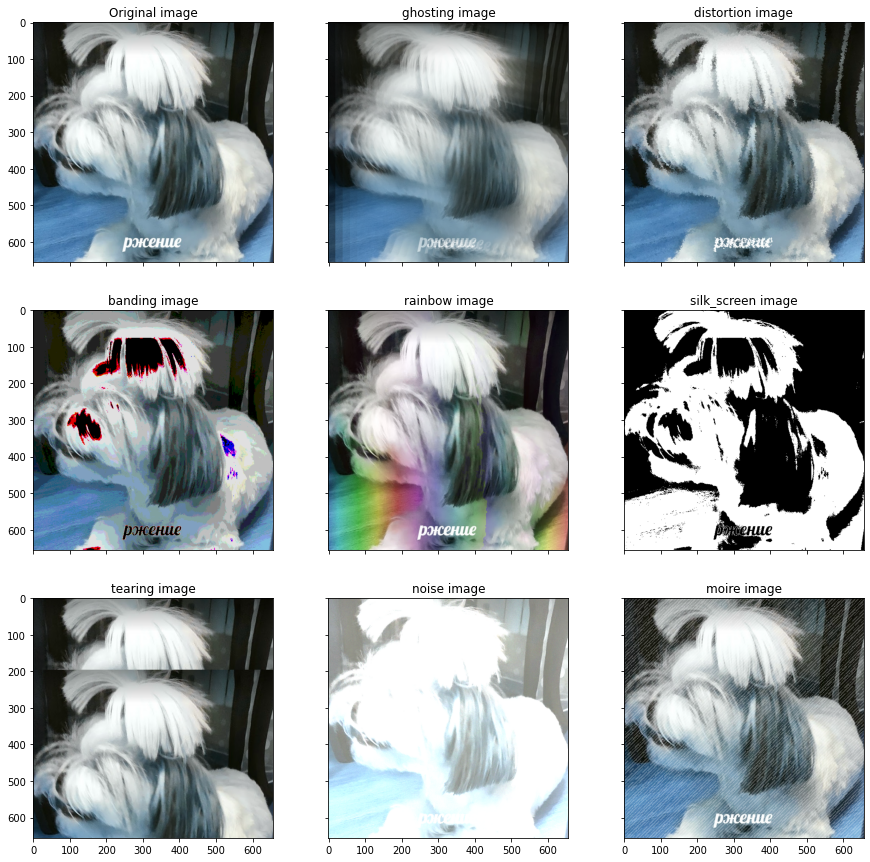

In [42]:
plot_x_examples(im, images, names, figsize=(15, 15))